In [2]:
# -----------------------------------------------------------------------------------
# Mini Project 2: Urban Heat Island (UHI) Analysis for Mangaluru using ML
# Team Members: Suyash, Adarsh, Subodh, Aditya
# Project Description: This project analyzes UHI effects in Mangaluru using remote 
# sensing data from ESA Land Cover, Landsat-9, and MODIS LST, leveraging machine 
# Learning to identify high-temperature zones and recommend mitigation strategies.
# Month: March 2025
# Course: CV381
# -----------------------------------------------------------------------------------

In [3]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import geopandas as gpd

Landcover shape: (21, 22)
Landsat shape: (21, 22)
LST shape: (21, 22)
Model Performance:
MAE: 0.87
R² Score: -0.62


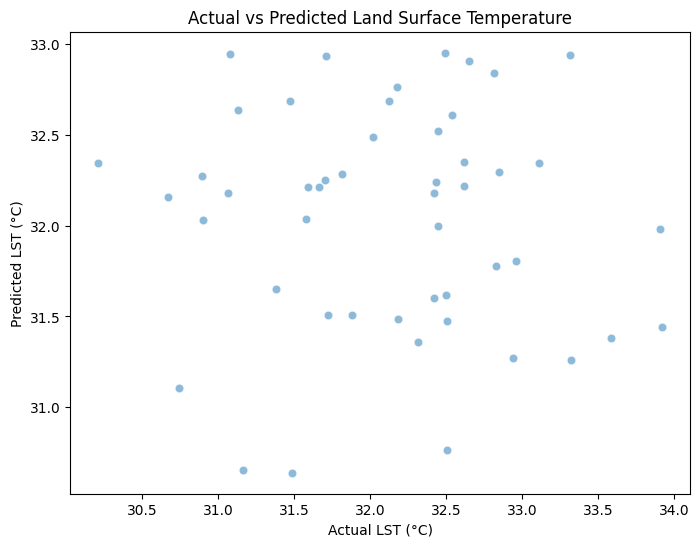

In [8]:
from rasterio.warp import reproject, Resampling

# ----------------------------
# Step 1: Load and Resample Rasters
# ----------------------------

def load_raster(file_path):
    """Loads raster data and returns the array and metadata."""
    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the first band
        meta = src.meta
    return array, meta

def resample_raster(source_array, source_meta, target_meta):
    """Resamples source raster to match the dimensions and resolution of the target raster."""
    target_array = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)

    reproject(
        source=source_array,
        destination=target_array,
        src_transform=source_meta['transform'],
        dst_transform=target_meta['transform'],
        src_crs=source_meta['crs'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.nearest  # Nearest neighbor resampling
    )
    return target_array

# Load datasets
landcover, landcover_meta = load_raster("/kaggle/input/satellite/Mangaluru_LandCover_ESA.tif")
landsat, landsat_meta = load_raster("/kaggle/input/satellite/Mangaluru_Landsat9.tif")
lst, lst_meta = load_raster("/kaggle/input/satellite/Mangaluru_MODIS_LST.tif")

# Resample all rasters to match MODIS LST (since LST is typically lower resolution)
landsat_resampled = resample_raster(landsat, landsat_meta, lst_meta)
landcover_resampled = resample_raster(landcover, landcover_meta, lst_meta)

# Ensure all arrays are the same shape
print(f"Landcover shape: {landcover_resampled.shape}")
print(f"Landsat shape: {landsat_resampled.shape}")
print(f"LST shape: {lst.shape}")  # LST is the reference

# ----------------------------
# Step 2: Prepare Data for ML
# ----------------------------
data = pd.DataFrame({
    "LandCover": landcover_resampled.flatten(),
    "Landsat_Brightness": landsat_resampled.flatten(),
    "LST": lst.flatten()
})

# Drop NaN values
data = data.dropna()

# Convert categorical land cover data to integer
data["LandCover"] = data["LandCover"].astype(int)

# ----------------------------
# Step 3: Train ML Model
# ----------------------------
X = data[["LandCover", "Landsat_Brightness"]]
y = data["LST"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# ----------------------------
# Step 4: Model Evaluation
# ----------------------------
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# ----------------------------
# Step 5: Visualization
# ----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual LST (°C)")
plt.ylabel("Predicted LST (°C)")
plt.title("Actual vs Predicted Land Surface Temperature")
plt.show()
